In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

In [3]:
dataset = load_dataset("allocine")

In [4]:
# Charger les mots positifs depuis le fichier
with open("positive_word.txt", "r") as f:
    positive_words = f.read().splitlines()

# Charger les mots négatifs depuis le fichier
with open("negative_word.txt", "r") as f:
    negative_words = f.read().splitlines()

In [5]:

# Diviser le dataset en données d'entraînement, de validation et de test
train_texts = [example["review"] for example in dataset["train"]]
train_labels = [example["label"] for example in dataset["train"]]
test_texts = [example["review"] for example in dataset["test"]]
test_labels = [example["label"] for example in dataset["test"]]


In [6]:
# un DataFrame à partir de vos données d'entraînement et de test
train_df = pd.DataFrame({'text': train_texts, 'label': train_labels})
test_df = pd.DataFrame({'text': test_texts, 'label': test_labels})

print(f"shape train {train_df.shape}")
print(f"shape test {test_df.shape}")


shape train (160000, 2)
shape test (20000, 2)


In [7]:
train_df.head(3)

,text,label
0,Si vous cherchez du cinéma abrutissant à tous ...,0
1,"Trash, re-trash et re-re-trash...! Une horreur...",0
2,"Et si, dans les 5 premières minutes du film, l...",0


In [8]:
neg=train_df[train_df.label==0]
neg.shape

(79413, 2)

In [9]:
pos=train_df[train_df.label==1]
pos.shape

(80587, 2)

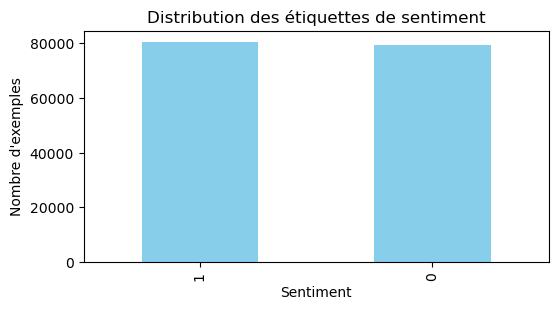

In [10]:
plt.figure(figsize=(6, 3))
train_df['label'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution des étiquettes de sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Nombre d\'exemples')
plt.show()

In [11]:
# Vectoriser les données textuelles (utilisation de TF-IDF)
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

In [12]:
# Tokenization et lemmatisation avec NLTK
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('french'))

In [13]:
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalnum()]
    tokens = [token for token in tokens if token.lower() not in stop_words]
    return " ".join(tokens)

In [14]:
train_texts_preprocessed = [preprocess_text(text) for text in train_texts]
test_texts_preprocessed = [preprocess_text(text) for text in test_texts]

# Vectoriser les données textuelles avec TF-IDF en utilisant scikit-learn
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_texts_preprocessed)
X_test = vectorizer.transform(test_texts_preprocessed)

# Entraîner un modèle de régression logistique
model = LogisticRegression()
model.fit(X_train, train_labels)

LogisticRegression()

In [15]:
# Enregistrer le modèle et le vectorizer en tant que fichiers pickle
with open('model_vectorizer.pkl', 'wb') as file:
    pickle.dump((model, vectorizer), file)

# Charger le modèle et le vectorizer depuis le fichier pickle
with open('model_vectorizer.pkl', 'rb') as file:
    loaded_model, loaded_vectorizer = pickle.load(file)

In [16]:
# Faire des prédictions sur les commentaires de test
predictions = loaded_model.predict(X_test)

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

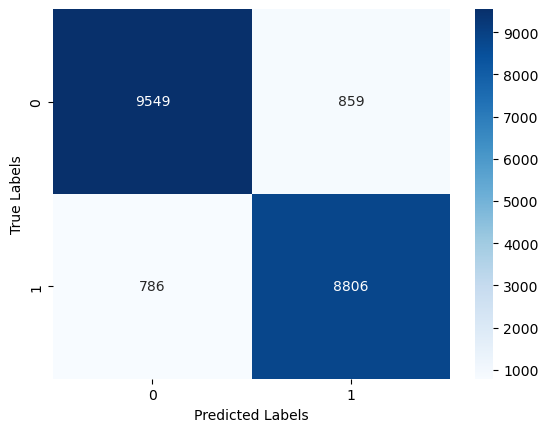

In [18]:
sn.heatmap(confusion_matrix(test_labels, predictions), annot=True, fmt='d',cmap='Blues')  # Utilisez 'd' pour un format décimal
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [19]:
# Extrayez les valeurs TP, TN, FP et FN de la matrice de confusion
TP = confusion_matrix(test_labels, predictions)[1, 1]
TN = confusion_matrix(test_labels, predictions)[0, 0]
FP = confusion_matrix(test_labels, predictions)[0, 1]
FN = confusion_matrix(test_labels, predictions)[1, 0]

# Calculez l'exactitude
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Calculez la précision
precision = TP / (TP + FP)
#calcul de score f1
f1 = f1_score(test_labels, predictions)

print(f"Exactitude : {accuracy}")
print(f"Précision : {precision}")
print(f"F-score : {f1}")

Exactitude : 0.91775
Précision : 0.9111226073460942
F-score : 0.9145765176299527


In [21]:
# Saisir des commentaires en entrée et effectuer des prédictions
while True:
    input_comment = input("Saisissez un commentaire (ou 'exit' pour quitter) : ")
    if input_comment.lower() == 'exit':
        break
    
    input_comment_preprocessed = preprocess_text(input_comment)
    input_comment_vectorized = loaded_vectorizer.transform([input_comment_preprocessed])
    prediction = loaded_model.predict(input_comment_vectorized)[0]
    
    sentiment = "Positif" if prediction == 1 else "Négatif"
    print(f"Sentiment prédit : {sentiment}")

Saisissez un commentaire (ou 'exit' pour quitter) : ce président est trop null
Sentiment prédit : Négatif
Saisissez un commentaire (ou 'exit' pour quitter) : exit
